# Google Drive Mounting

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Generator

In [0]:
import numpy as np 
import matplotlib.pyplot as plt

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [0]:
import scipy.io         # for loading .mat ground truth files 
from PIL import Image   # for loading images to be resized 

In [0]:
import scipy.ndimage as nd

def bwdist(mask):
    return nd.distance_transform_edt(np.logical_not(mask))

def mask2levelSet(mask):
    return bwdist(mask) - bwdist(1 - mask)

In [0]:
!python generateMasks.py "/content/drive/My Drive/DeepLevelSet/train_images" "/content/drive/My Drive/DeepLevelSet/train_masks"

In [0]:
class Dataset(Dataset):
  def __init__(self, list_IDs):
        'Initialization'
        self.list_IDs = list_IDs
        self.base_url = "/content/drive/My Drive/DeepLevelSet"

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        ID = self.list_IDs[index]
        fileName = ID.split('.')[0]                                 # name without file extension  

        X_img = Image.open(f"{self.base_url}/train_images/{ID}")    # loading image
        X_img = X_img.resize((224, 224))                            # resizing to 224x224 
        X_img = transforms.functional.to_tensor(X_img)              # PIL image to Tensor 
        
        X_mask = np.load(f"{self.base_url}/train_masks/{fileName}.npy")
        phi_init = mask2levelSet(X_mask).astype("float32")          # mask to level set
        X_mask = transforms.functional.to_tensor(phi_init)          # converting to tensor 

        X = torch.cat((X_img, X_mask), dim=0)                       # X = [X_img, X_mask]
        
        yMat = scipy.io.loadmat(f"{self.base_url}/groundTruth/{fileName}.mat")
        y = yMat['groundTruth'][0][0][0][0][0] - 1                  # fetching ground truth mask 
        y = Image.fromarray(y)                                      # converting to PIL image 
        y = y.resize((224, 224))                                    # resizing to 224x224
        y = np.asarray(y)                                           # converting back to array 
        phi_gt =  mask2levelSet(y).astype("float32")                # mask to level set

        Y = phi_init - phi_gt                                       # difference of levelsets 
        Y = Y / np.abs(np.where(Y == 0, 1, Y))                      # normalizing 
        Y = transforms.functional.to_tensor(Y)                      # to tensor 
        Y = torch.squeeze(Y.view(-1, 1))                            # reshaping into a vector 

        return X, Y

# Model Definition

In [0]:
import torchvision.models as models

In [0]:
# loading pretrained resnet101
model = models.resnet101(pretrained=True)

In [0]:
# modifying first conv layer for 4 channel input
weight_conv1 = model.conv1.weight.clone()

model.conv1 = torch.nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
with torch.no_grad():
    model.conv1.weight[:, :3] = weight_conv1
    model.conv1.weight[:, 3] = model.conv1.weight[:, 0]

In [0]:
# modifying last layer 
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, out_features=224*224),
    torch.nn.Sigmoid()
)

In [0]:
# unfreezing model layers 
for name, param in model.named_parameters():
    try:
        param.requires_grad = True
    except Exception as e: 
        print(f"{name}: {e}")

In [0]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# moving model to GPU if available
model.to(device)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Data Loader

In [0]:
import os

In [0]:
dirs = os.listdir("/content/drive/My Drive/DeepLevelSet/train_images")
partition = {
    'train': dirs
    }

In [0]:
params = {
    'batch_size': 32,
    'shuffle': True,
    'num_workers': 6
    }

training_set = Dataset(partition['train'])
training_generator = DataLoader(training_set, **params)

# Model Training 

In [0]:
from torch import optim

In [0]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters()) 

In [0]:
epochs = 200

train_losses = []
for e in range(epochs):
    running_loss = 0
    for local_batch, local_labels in training_generator:
        inputs, labels = local_batch.to(device), local_labels.to(device)
        F = model(inputs)
        loss = criterion(2*F-1, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss/len(training_generator))

    print(f"Epoch: {e+1}/{epochs}.. Training Loss: {running_loss/len(training_generator):.4f}")

Epoch: 1/200.. Training Loss: 0.7405
Epoch: 2/200.. Training Loss: 0.6530
Epoch: 3/200.. Training Loss: 0.6213
Epoch: 4/200.. Training Loss: 0.5954
Epoch: 5/200.. Training Loss: 0.5730
Epoch: 6/200.. Training Loss: 0.5465
Epoch: 7/200.. Training Loss: 0.5328
Epoch: 8/200.. Training Loss: 0.5248
Epoch: 9/200.. Training Loss: 0.5202
Epoch: 10/200.. Training Loss: 0.5246
Epoch: 11/200.. Training Loss: 0.5098
Epoch: 12/200.. Training Loss: 0.5242
Epoch: 13/200.. Training Loss: 0.5119
Epoch: 14/200.. Training Loss: 0.5083
Epoch: 15/200.. Training Loss: 0.5024
Epoch: 16/200.. Training Loss: 0.5017
Epoch: 17/200.. Training Loss: 0.5029
Epoch: 18/200.. Training Loss: 0.5019
Epoch: 19/200.. Training Loss: 0.4866
Epoch: 20/200.. Training Loss: 0.4868
Epoch: 21/200.. Training Loss: 0.4876
Epoch: 22/200.. Training Loss: 0.4795
Epoch: 23/200.. Training Loss: 0.4714
Epoch: 24/200.. Training Loss: 0.4739
Epoch: 25/200.. Training Loss: 0.4660
Epoch: 26/200.. Training Loss: 0.4828
Epoch: 27/200.. Train

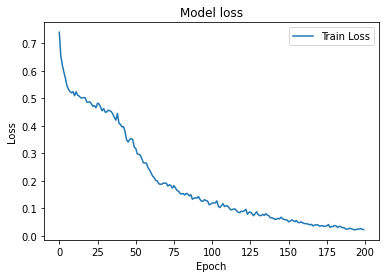

In [0]:
plt.plot(train_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'])
plt.show()

In [0]:
# saving model 
BASE_URL = "/content/drive/My Drive/DeepLevelSet"

torch.save(model.state_dict(), f"{BASE_URL}/checkpoint.pth" )

# Model Testing

In [0]:
BASE_URL = "/content/drive/My Drive/DeepLevelSet"

In [0]:
def grad(x):
    return np.array(np.gradient(x))

def norm(x, axis=0):
    return np.sqrt(np.sum(np.square(x), axis=axis))

In [0]:
def test_preprocess(img, phi): 
    X_img = transforms.functional.to_tensor(img)  # PIL image to Tensor
    X_mask = transforms.functional.to_tensor(phi.astype("float32") )    # converting to tensor 
    X = torch.cat((X_img, X_mask), dim=0)   # X = [X_img, X_mask]

    return X

In [0]:
def predict(X_img, phi): 
    with torch.no_grad():
        model.eval()

        # preperaing model input 
        X = test_preprocess(X_img, phi)
        X = X.unsqueeze(0)
        X = X.to(device)
        
        # getting model prediction 
        F = 2*model(X)-1
        F = F.view(224, 224)
        F = F.cpu().numpy()

        # updating level Set 
        dphi = grad(phi)
        dphi_norm = norm(dphi)

        dphi_t = F * dphi_norm

        return phi + dphi_t 

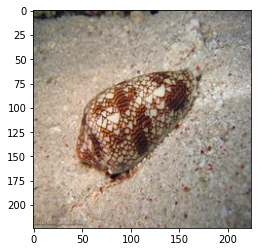

In [0]:
ID = "1.jpg"
X_img = Image.open(f"{BASE_URL}/train_images/{ID}")    # loading image
X_img = X_img.resize((224, 224))                       # resizing to 224x224
plt.imshow(X_img)

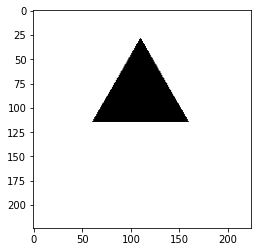

In [0]:
mask_init = np.load(f"{BASE_URL}/train_masks/{2}.npy")
plt.imshow(mask_init, cmap='gray')

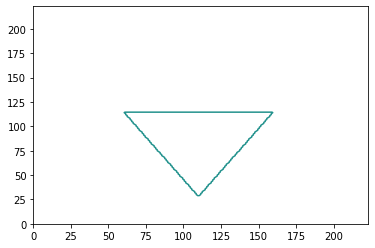

In [0]:
phi = mask2levelSet(mask_init)
plt.contour(phi, 0)

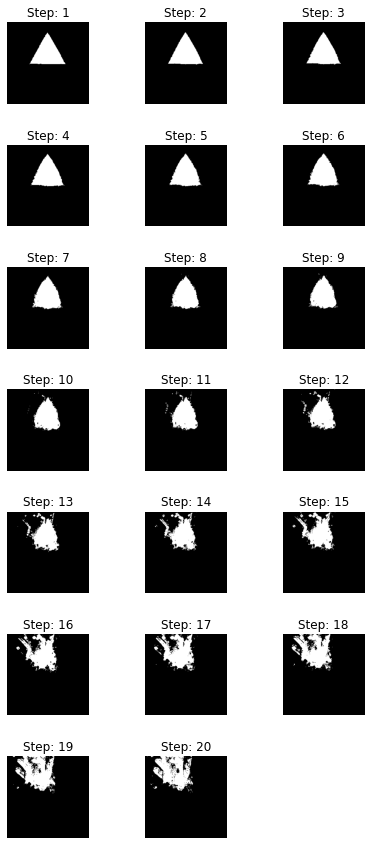

In [0]:
STEPS = 20

fig = plt.figure(figsize=(7, 15))
cols = 3
rows = int(np.ceil(STEPS / 3))
for i in range(STEPS):
    phi = predict(X_img, phi)

    # displaying contnour 
    fig.add_subplot(rows, cols, i+1)
    plt.title(f"Step: {i+1}")
 
    plt.imshow(phi/np.abs(phi), cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
